In [1]:
import sys
import os

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.append(project_root)

import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import set_seed

from tiingo_data.download_data import get_daily_returns_data_cached
from utils import get_device
from core.data import create_multivariate_windows, train_val_split, prepare_data_for_chronos
from core.eval import (
    run_chronos_sliding_backtest,
    summarize_backtest_results,
    evaluate_model_on_test,
    compare_models,
)
from chronos import Chronos2Pipeline

In [3]:
# Load and prepare data
df_all = get_daily_returns_data_cached()
df_train_clean, df_eval_clean = prepare_data_for_chronos(df_all, test_size=1200)

print(f"Training data shape: {df_train_clean.shape}")
print(f"Eval data shape: {df_eval_clean.shape}")

set_seed(42)

# Hyperparameters
context_length = 200
prediction_length = 1
stride = 50
learning_rate = 1e-5
num_steps = 100
batch_size = 100

gics_level_1 = {
    "Information Technology": [
        "AAPL", "ADBE", "ADI", "AMD", "AMAT", "CSCO", "FIS",
        "IBM", "INTC", "INTU", "LRCX", "MSFT", "MU",
        "NVDA", "ORCL", "QCOM", "TXN"
    ],
    "Health Care": [
        "ABBV", "ABT", "AMGN", "BDX", "BMY", "CVS", "DHR",
        "ELV", "GILD", "HUM", "ISRG", "JNJ",
        "LLY", "MRK", "PFE", "REGN", "SYK", "TMO", "VRTX", "ZTS"
    ],
    "Financials": [
        "AIG", "AXP", "BAC", "BLK", "C", "CB", "CI",
        "COF", "GS", "JPM", "MET", "MS",
        "PNC", "PGR", "SCHW", "USB", "WFC"
    ],
    "Consumer Discretionary": [
        "AMZN", "BKNG", "HD", "LOW", "MCD",
        "META", "NFLX", "NKE", "SBUX",
        "TGT", "TJX"
    ],
    "Consumer Staples": [
        "CL", "COST", "EL", "KMB", "KO",
        "MDLZ", "MO", "PEP", "PG", "PM", "WMT"
    ],
    "Industrials": [
        "BA", "CAT", "CSX", "DE", "EMR",
        "ETN", "FDX", "GD", "GE", "HON",
        "ITW", "LMT", "MMM", "NSC",
        "RTX", "UNP", "UPS", "WM"
    ],
    "Energy": [
        "COP", "CVX", "EOG", "OXY", "SLB", "XOM"
    ],
    "Communication Services": [
        "CMCSA", "CRM", "GOOG", "GOOGL",
        "T", "TMUS", "VZ"
    ],
    "Materials": [
        "APD", "LIN", "SHW"
    ],
    "Real Estate": [
        "AMT", "SPG"
    ],
    "Utilities": [
        # nessuna delle aziende fornite rientra qui
    ],
}

def slugify(category: str) -> str:
    return (
        category.lower()
        .replace("&", "and")
        .replace("/", "_")
        .replace(" ", "_")
    )

# Create multivariate windows (full universe, no group IDs)
all_inputs = create_multivariate_windows(
    df_train_clean,
    context_length=context_length,
    prediction_length=prediction_length,
    stride=stride,
)
print(f"Total training windows: {len(all_inputs)}")
print(f"Each window shape: {all_inputs[0]['target'].shape}")

# Train/validation split (full universe)
train_inputs, val_inputs = train_val_split(all_inputs, val_ratio=0.1)
print(f"Train samples: {len(train_inputs)}, Val samples: {len(val_inputs)}")

# Build per-category datasets (train/val/eval)
category_datasets = {}
for category, tickers in gics_level_1.items():
    available = [ticker for ticker in tickers if ticker in df_train_clean.columns]
    if not available:
        continue
    category_train_df = df_train_clean[available]
    category_eval_df = df_eval_clean[available]
    category_inputs = create_multivariate_windows(
        category_train_df,
        context_length=context_length,
        prediction_length=prediction_length,
        stride=stride,
    )
    category_train_inputs, category_val_inputs = train_val_split(category_inputs, val_ratio=0.1)
    category_datasets[category] = {
        "tickers": available,
        "train_inputs": category_train_inputs,
        "val_inputs": category_val_inputs,
        "eval_df": category_eval_df,
        "output_dir": f"outputs/chronos2_sft/{slugify(category)}",
    }
    print(
        f"{category}: {len(available)} tickers, {len(category_train_inputs)} train, {len(category_val_inputs)} val"
    )

# Load model
pipeline = Chronos2Pipeline.from_pretrained(
    "amazon/chronos-2",
    device_map=get_device(),
    dtype=torch.float32,
)
import os

BASE_OUTDIR = "outputs/chronos2_sft" 
def safe_dirname(name: str) -> str:
    # evita spazi e caratteri strani nei nomi cartella
    return str(name).strip().replace(" ", "_").replace("/", "_")


print(f"Model device: {pipeline.model.device}")
print(f"Model dtype: {next(pipeline.model.parameters()).dtype}")

Training data shape: (2797, 114)
Eval data shape: (1200, 114)
Total training windows: 52
Each window shape: (114, 201)
Train samples: 46, Val samples: 6
Information Technology: 17 tickers, 46 train, 6 val
Health Care: 18 tickers, 46 train, 6 val
Financials: 17 tickers, 46 train, 6 val
Consumer Discretionary: 10 tickers, 46 train, 6 val
Consumer Staples: 11 tickers, 46 train, 6 val
Industrials: 18 tickers, 46 train, 6 val
Energy: 6 tickers, 46 train, 6 val
Communication Services: 6 tickers, 46 train, 6 val
Materials: 2 tickers, 46 train, 6 val
Real Estate: 2 tickers, 46 train, 6 val
Model device: cuda:0
Model dtype: torch.float32


In [4]:
from pathlib import Path
import pandas as pd
import gc
import torch

def cleanup_cuda():
    gc.collect()
    if torch.cuda.is_available():
        try:
            torch.cuda.synchronize()
        except Exception:
            pass
        torch.cuda.empty_cache()
        try:
            torch.cuda.ipc_collect()
        except Exception:
            pass

CSV_CANDIDATES = [
    Path("notebooks/outputs/tuning_results/tuning_best_results.csv"),
    Path("outputs/tuning_results/tuning_best_results.csv"),
]
best_csv_path = next((p for p in CSV_CANDIDATES if p.exists()), None)
if best_csv_path is None:
    raise FileNotFoundError(
        "Non trovo tuning_best_results.csv. Ho cercato:\n" + "\n".join(map(str, CSV_CANDIDATES))
    )

df_best = pd.read_csv(best_csv_path)
df_best["group"] = df_best["group"].astype(str).str.strip()
hp_by_group = df_best.set_index("group").to_dict(orient="index")

def get_hparams(group: str):
    g = str(group).strip()
    if g not in hp_by_group:
        raise KeyError(f"Group '{g}' non presente nel CSV. Disponibili: {sorted(hp_by_group.keys())}")
    row = hp_by_group[g]
    return dict(
        prediction_length=prediction_length,
        context_length=int(row["context_length"]),
        num_steps=int(row["num_steps"]),
        batch_size=int(row["batch_size"]),
        learning_rate=float(row["learning_rate"]),
        stride=int(row.get("stride", 50)),
        n_eval_samples=int(row.get("n_eval_samples", 100)),
    )

def make_train_val_inputs(df_wide, hp, val_ratio=0.1):
    windows = create_multivariate_windows(
        df_wide,
        context_length=hp["context_length"],
        prediction_length=prediction_length,
        stride=hp["stride"],
    )
    tr, va = train_val_split(windows, val_ratio=val_ratio)
    del windows
    cleanup_cuda()
    return tr, va

def load_base_pipeline(dtype=torch.float32):
    return Chronos2Pipeline.from_pretrained(
        "amazon/chronos-2",
        device_map=get_device(),
        dtype=dtype,
    )


In [5]:
cleanup_cuda()

global_hp = get_hparams("global")
print(
    f"[BASELINE/GLOBAL HP] ctx={global_hp['context_length']} "
    f"n_eval_samples={global_hp['n_eval_samples']}"
)

# Baseline zero-shot: modello base
baseline_pipeline = load_base_pipeline(dtype=torch.float32)

print("Evaluating ZERO-SHOT baseline on global test set...")
baseline_global_results = evaluate_model_on_test(
    pipeline=baseline_pipeline,
    df_test=df_eval_clean,
    context_length=global_hp["context_length"],

    n_samples=global_hp["n_eval_samples"],
)

print("\n=== ZERO-SHOT (GLOBAL) ===")
print(f"Mean Quantile Loss: {baseline_global_results['mean_quantile_loss']:.6f} ± {baseline_global_results['std_quantile_loss']:.6f}")
print(f"Mean MSE: {baseline_global_results['mean_mse']:.6f}")
print(f"Mean MAE: {baseline_global_results['mean_mae']:.6f}")

# Baseline zero-shot per categoria (stesso prediction_length della categoria)
baseline_by_category = {}

for category, payload in category_datasets.items():
    cat_hp = get_hparams(category)

    print(f"\nEvaluating ZERO-SHOT baseline for category: {category}")
    res = evaluate_model_on_test(
        pipeline=baseline_pipeline,
        df_test=payload["eval_df"],
        context_length=cat_hp["context_length"],
        n_samples=cat_hp["n_eval_samples"],
    )
    baseline_by_category[category] = res

    print(f"  Baseline Quantile Loss: {res['mean_quantile_loss']:.6f}")
    print(f"  Baseline MSE: {res['mean_mse']:.6f}")
    print(f"  Baseline MAE: {res['mean_mae']:.6f}")

cleanup_cuda()


[BASELINE/GLOBAL HP] ctx=128 n_eval_samples=100
Evaluating ZERO-SHOT baseline on global test set...

=== ZERO-SHOT (GLOBAL) ===
Mean Quantile Loss: 0.007329 ± 0.003841
Mean MSE: 0.000547
Mean MAE: 0.016543

Evaluating ZERO-SHOT baseline for category: Information Technology
  Baseline Quantile Loss: 0.009238
  Baseline MSE: 0.000802
  Baseline MAE: 0.020902

Evaluating ZERO-SHOT baseline for category: Health Care
  Baseline Quantile Loss: 0.006834
  Baseline MSE: 0.000402
  Baseline MAE: 0.015224

Evaluating ZERO-SHOT baseline for category: Financials
  Baseline Quantile Loss: 0.006975
  Baseline MSE: 0.000475
  Baseline MAE: 0.015540

Evaluating ZERO-SHOT baseline for category: Consumer Discretionary
  Baseline Quantile Loss: 0.007758
  Baseline MSE: 0.000586
  Baseline MAE: 0.017302

Evaluating ZERO-SHOT baseline for category: Consumer Staples
  Baseline Quantile Loss: 0.005466
  Baseline MSE: 0.000273
  Baseline MAE: 0.012191

Evaluating ZERO-SHOT baseline for category: Industrials
 

In [6]:
cleanup_cuda()

global_hp = get_hparams("global")
print(
    f"\n[GLOBAL FT] steps={global_hp['num_steps']} lr={global_hp['learning_rate']} "
    f"ctx={global_hp['context_length']} "
    f"bs={global_hp['batch_size']} stride={global_hp['stride']}"
)

pipeline_global = load_base_pipeline(dtype=torch.float32)

global_train_inputs, global_val_inputs = make_train_val_inputs(df_train_clean, global_hp, val_ratio=0.1)


finetuned_general = pipeline_global.fit(
    inputs=global_train_inputs,
    validation_inputs=global_val_inputs,
    prediction_length=prediction_length,
    context_length=global_hp["context_length"],
    min_past=global_hp["context_length"],
    num_steps=global_hp["num_steps"],
    batch_size=global_hp["batch_size"],
    learning_rate=global_hp["learning_rate"],
    finetune_mode="full",
    output_dir="outputs/chronos2_sft/general",
    # opzionale per vedere meglio i log:
    # logging_steps=20, eval_steps=20, save_steps=20
)

del global_train_inputs, global_val_inputs, pipeline_global
cleanup_cuda()

print("\nEvaluating fine-tuned GENERAL model on global test set...")
general_results_global = evaluate_model_on_test(
    pipeline=finetuned_general,
    df_test=df_eval_clean,
    context_length=global_hp["context_length"],
    n_samples=global_hp["n_eval_samples"],
)

print("\n=== GENERAL FINE-TUNED (GLOBAL TEST) ===")
print(f"Mean Quantile Loss: {general_results_global['mean_quantile_loss']:.6f} ± {general_results_global['std_quantile_loss']:.6f}")
print(f"Mean MSE: {general_results_global['mean_mse']:.6f}")
print(f"Mean MAE: {general_results_global['mean_mae']:.6f}")



[GLOBAL FT] steps=1500 lr=3.113813151474403e-06 ctx=128 bs=48 stride=100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.501800,0.486325
200,0.415900,0.478257
300,0.379600,0.523708
400,0.338800,0.534763
500,0.296500,0.534400
600,0.281000,0.534644
700,0.273900,0.558673
800,0.246700,0.559172
900,0.244300,0.554356
1000,0.236600,0.559796



Evaluating fine-tuned GENERAL model on global test set...

=== GENERAL FINE-TUNED (GLOBAL TEST) ===
Mean Quantile Loss: 0.006153 ± 0.003333
Mean MSE: 0.000443
Mean MAE: 0.014164


In [7]:
cleanup_cuda()

category_comparisons = {}

for category, payload in category_datasets.items():
    try:
        cleanup_cuda()

        cat_hp = get_hparams(category)
        available = [t for t in payload["tickers"] if t in df_train_clean.columns]
        if not available:
            print(f"\n[{category}] skip: nessun ticker disponibile nel training df.")
            continue

        print(
            f"\n[{category}] FT hp: steps={cat_hp['num_steps']} lr={cat_hp['learning_rate']} "
            f"ctx={cat_hp['context_length']} "
            f"bs={cat_hp['batch_size']} stride={cat_hp['stride']} | tickers={len(available)}"
        )

        # Train df categoria
        cat_train_df = df_train_clean[available]

        # Pipeline base pulita per questo fine-tune
        pipeline_cat = load_base_pipeline(dtype=torch.float32)

        cat_train_inputs, cat_val_inputs = make_train_val_inputs(cat_train_df, cat_hp, val_ratio=0.1)

        cat_model = pipeline_cat.fit(
            inputs=cat_train_inputs,
            validation_inputs=cat_val_inputs,
            prediction_length=prediction_length,
            context_length=cat_hp["context_length"],
            min_past=cat_hp["context_length"],
            num_steps=cat_hp["num_steps"],
            batch_size=cat_hp["batch_size"],
            learning_rate=cat_hp["learning_rate"],
            finetune_mode="full",
            output_dir=payload["output_dir"],
            # opzionale per log più frequenti:
            # logging_steps=20, eval_steps=20, save_steps=20
        )

        del cat_train_inputs, cat_val_inputs, pipeline_cat
        cleanup_cuda()

        # ---- Valori assoluti ----
        baseline_cat_results = baseline_by_category.get(category)
        if baseline_cat_results is None:
            # fallback: calcola al volo se non l’hai fatto in Cella 2
            baseline_cat_results = evaluate_model_on_test(
                pipeline=baseline_pipeline,
                df_test=payload["eval_df"],
                context_length=cat_hp["context_length"],
                n_samples=cat_hp["n_eval_samples"],
            )

        general_cat_results = evaluate_model_on_test(
            pipeline=finetuned_general,
            df_test=payload["eval_df"],
            context_length=get_hparams("global")["context_length"],  # context del general
            n_samples=cat_hp["n_eval_samples"],
        )

        category_results = evaluate_model_on_test(
            pipeline=cat_model,
            df_test=payload["eval_df"],
            context_length=cat_hp["context_length"],
            n_samples=cat_hp["n_eval_samples"],
        )

        # ---- Confronti % ----
        comp_cat_vs_general = compare_models(general_cat_results, category_results)
        comp_cat_vs_baseline = compare_models(baseline_cat_results, category_results)

        category_comparisons[category] = {
            "baseline": baseline_cat_results,
            "general_finetuned": general_cat_results,
            "category_finetuned": category_results,
            "comparison_cat_vs_general": comp_cat_vs_general,
            "comparison_cat_vs_baseline": comp_cat_vs_baseline,
            "hparams_category": cat_hp,
            "hparams_global": get_hparams("global"),
        }

        # ---- Print: valori assoluti + % ----
        print(f"\n[{category}] ABSOLUTE METRICS")
        print(f"  Baseline   | QL={baseline_cat_results['mean_quantile_loss']:.6f}  MSE={baseline_cat_results['mean_mse']:.6f}  MAE={baseline_cat_results['mean_mae']:.6f}")
        print(f"  General FT | QL={general_cat_results['mean_quantile_loss']:.6f}  MSE={general_cat_results['mean_mse']:.6f}  MAE={general_cat_results['mean_mae']:.6f}")
        print(f"  CategoryFT | QL={category_results['mean_quantile_loss']:.6f}  MSE={category_results['mean_mse']:.6f}  MAE={category_results['mean_mae']:.6f}")

        print(f"[{category}] IMPROVEMENTS (%)")
        print(f"  vs General  | QL {comp_cat_vs_general['quantile_loss_improvement']:+.2f}%  MSE {comp_cat_vs_general['mse_improvement']:+.2f}%  MAE {comp_cat_vs_general['mae_improvement']:+.2f}%")
        print(f"  vs Baseline | QL {comp_cat_vs_baseline['quantile_loss_improvement']:+.2f}%  MSE {comp_cat_vs_baseline['mse_improvement']:+.2f}%  MAE {comp_cat_vs_baseline['mae_improvement']:+.2f}%")

        # IMPORTANT: libera modello categoria
        del cat_model
        cleanup_cuda()
    except Exception as e:
        print(f"The training for category [{category}] failed. \n Log Error: {e}")
        cleanup_cuda()



print("\nDone. category_comparisons contiene tutti i valori assoluti + percentuali.")


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: f2351622-b65f-4416-8122-5ea4404e0ec3)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 1s [Retry 1/5].



[Information Technology] FT hp: steps=1500 lr=4.757865681955919e-05 ctx=96 bs=48 stride=100 | tickers=17


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: b10de714-639f-4f67-86f0-0bd74f6fe68e)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: a2947d1d-824a-43c7-8c82-9b9ab6d73817)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 4s [Retry 3/

Step,Training Loss,Validation Loss
100,0.296600,0.896922
200,0.127300,0.880416
300,0.081700,0.811171
400,0.059300,0.878423
500,0.042300,0.856311
600,0.036400,0.897925
700,0.032800,0.857505
800,0.028100,0.897201
900,0.023400,0.921010
1000,0.021500,0.904051



[Information Technology] ABSOLUTE METRICS
  Baseline   | QL=0.009238  MSE=0.000802  MAE=0.020902
  General FT | QL=0.008386  MSE=0.000779  MAE=0.019026
  CategoryFT | QL=0.007947  MSE=0.000578  MAE=0.016671
[Information Technology] IMPROVEMENTS (%)
  vs General  | QL +5.25%  MSE +25.80%  MAE +12.38%
  vs Baseline | QL +13.98%  MSE +27.88%  MAE +20.24%


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 6cad06ea-453c-413e-b363-6e736df24d36)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 1s [Retry 1/5].



[Health Care] FT hp: steps=600 lr=1.8494433914224897e-05 ctx=192 bs=56 stride=50 | tickers=18


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: f0925381-b4a4-41dd-9330-eb4a049de7cb)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 26ed26f3-fba4-487c-bac2-1115e0b79d5e)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 4s [Retry 3/

Step,Training Loss,Validation Loss
100,0.421200,0.459165
200,0.183400,0.515360
300,0.113300,0.515970
400,0.091700,0.542458
500,0.073200,0.557244
600,0.063200,0.563110



[Health Care] ABSOLUTE METRICS
  Baseline   | QL=0.006834  MSE=0.000402  MAE=0.015224
  General FT | QL=0.005775  MSE=0.000351  MAE=0.013206
  CategoryFT | QL=0.005153  MSE=0.000256  MAE=0.011886
[Health Care] IMPROVEMENTS (%)
  vs General  | QL +10.78%  MSE +27.08%  MAE +10.00%
  vs Baseline | QL +24.60%  MSE +36.40%  MAE +21.92%


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 7a1004b3-31d2-41ba-a13c-f6eee8f45067)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 1s [Retry 1/5].



[Financials] FT hp: steps=200 lr=3.6919130330522415e-06 ctx=192 bs=88 stride=75 | tickers=17


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: ad3eb7c5-c4e5-4e5a-8dd0-c579d644d6d3)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 9f0b0442-5c17-4fef-809f-437bcc483f4a)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 4s [Retry 3/

Step,Training Loss,Validation Loss
100,0.436100,0.417963
200,0.283800,0.429273



[Financials] ABSOLUTE METRICS
  Baseline   | QL=0.006975  MSE=0.000475  MAE=0.015540
  General FT | QL=0.006179  MSE=0.000404  MAE=0.014318
  CategoryFT | QL=0.006099  MSE=0.000385  MAE=0.013634
[Financials] IMPROVEMENTS (%)
  vs General  | QL +1.28%  MSE +4.55%  MAE +4.78%
  vs Baseline | QL +12.55%  MSE +18.86%  MAE +12.26%


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 2185e9b8-d4ad-4cda-b31f-8b4fdf0aa202)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 1s [Retry 1/5].



[Consumer Discretionary] FT hp: steps=200 lr=4.85841149653781e-05 ctx=192 bs=96 stride=100 | tickers=10


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 4c0367b4-4fd9-437b-a8df-7fc8cdb41d80)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 19f99a12-30f7-493d-9f58-36376456d251)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 4s [Retry 3/

Step,Training Loss,Validation Loss
100,0.171800,0.447632
200,0.048000,0.474531



[Consumer Discretionary] ABSOLUTE METRICS
  Baseline   | QL=0.007758  MSE=0.000586  MAE=0.017302
  General FT | QL=0.006733  MSE=0.000503  MAE=0.015249
  CategoryFT | QL=0.006316  MSE=0.000384  MAE=0.013249
[Consumer Discretionary] IMPROVEMENTS (%)
  vs General  | QL +6.19%  MSE +23.67%  MAE +13.11%
  vs Baseline | QL +18.59%  MSE +34.49%  MAE +23.43%


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 564eacdb-2fa2-48cb-820f-24c4ff82c38d)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 1s [Retry 1/5].



[Consumer Staples] FT hp: steps=600 lr=4.588132396264929e-05 ctx=256 bs=96 stride=75 | tickers=11


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: c71af841-db05-40e1-99e0-eec22550a870)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 53ebc14c-0ebe-4a20-906d-ebab2eba3cd5)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 4s [Retry 3/

Step,Training Loss,Validation Loss
100,0.246500,0.745822
200,0.066300,0.820706
300,0.044000,0.811690
400,0.032100,0.804211
500,0.025500,0.808579
600,0.021600,0.812990



[Consumer Staples] ABSOLUTE METRICS
  Baseline   | QL=0.005466  MSE=0.000273  MAE=0.012191
  General FT | QL=0.004760  MSE=0.000291  MAE=0.010891
  CategoryFT | QL=0.004816  MSE=0.000216  MAE=0.010375
[Consumer Staples] IMPROVEMENTS (%)
  vs General  | QL -1.18%  MSE +25.82%  MAE +4.74%
  vs Baseline | QL +11.89%  MSE +20.85%  MAE +14.90%


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 930e6cb6-a7cf-4fd3-8989-78c37d259a8d)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 1s [Retry 1/5].



[Industrials] FT hp: steps=1300 lr=9.19203063802769e-06 ctx=192 bs=72 stride=100 | tickers=18


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 64ff8244-d318-4b28-a760-1106d776b2ba)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: e41304f6-75b3-4c75-9e37-d5573eae7bf9)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 4s [Retry 3/

Step,Training Loss,Validation Loss
100,0.336200,0.555799
200,0.152600,0.474114
300,0.106500,0.516637
400,0.087100,0.516820
500,0.075100,0.490022
600,0.066100,0.541894
700,0.060200,0.555975
800,0.056100,0.545392
900,0.050700,0.547188
1000,0.048300,0.544060



[Industrials] ABSOLUTE METRICS
  Baseline   | QL=0.006788  MSE=0.000402  MAE=0.015173
  General FT | QL=0.005856  MSE=0.000358  MAE=0.013229
  CategoryFT | QL=0.005676  MSE=0.000301  MAE=0.012418
[Industrials] IMPROVEMENTS (%)
  vs General  | QL +3.08%  MSE +15.83%  MAE +6.13%
  vs Baseline | QL +16.39%  MSE +25.12%  MAE +18.16%


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: eb16f6fd-1505-498e-82a0-5dbe3bdbe7b9)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 1s [Retry 1/5].



[Energy] FT hp: steps=300 lr=4.968573113330312e-05 ctx=256 bs=8 stride=100 | tickers=6


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 8acdecb3-97cd-4c13-b360-5b9da0efc427)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: c29e00c7-ee95-4e9e-b728-508e10aaa22d)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 4s [Retry 3/

Step,Training Loss,Validation Loss
100,0.331600,0.681276
200,0.120300,0.745249
300,0.050200,0.798461



[Energy] ABSOLUTE METRICS
  Baseline   | QL=0.007631  MSE=0.000525  MAE=0.017198
  General FT | QL=0.006289  MSE=0.000393  MAE=0.014619
  CategoryFT | QL=0.005490  MSE=0.000302  MAE=0.012989
[Energy] IMPROVEMENTS (%)
  vs General  | QL +12.69%  MSE +23.16%  MAE +11.15%
  vs Baseline | QL +28.05%  MSE +42.50%  MAE +24.47%


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: bf012acb-2679-4003-80fc-611435394039)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 1s [Retry 1/5].



[Communication Services] FT hp: steps=1500 lr=2.1824625252932308e-05 ctx=128 bs=32 stride=75 | tickers=6


'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 4de76a87-edc5-488b-81cd-885bd94b223a)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 2s [Retry 2/5].
'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /amazon/chronos-2/resolve/main/adapter_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno 11001] getaddrinfo failed)"))'), '(Request ID: 120b9f9f-ea9d-4f18-82c2-10d09eb7ebd1)')' thrown while requesting HEAD https://huggingface.co/amazon/chronos-2/resolve/main/adapter_config.json
Retrying in 4s [Retry 3/

Step,Training Loss,Validation Loss
100,0.227500,0.634131
200,0.088200,0.644900
300,0.060700,0.654717
400,0.048400,0.643240
500,0.041900,0.671778
600,0.037500,0.669370
700,0.033000,0.653872
800,0.028700,0.672415
900,0.025600,0.674086
1000,0.024600,0.676900



[Communication Services] ABSOLUTE METRICS
  Baseline   | QL=0.006763  MSE=0.000398  MAE=0.015012
  General FT | QL=0.005710  MSE=0.000310  MAE=0.012920
  CategoryFT | QL=0.005017  MSE=0.000237  MAE=0.011137
[Communication Services] IMPROVEMENTS (%)
  vs General  | QL +12.14%  MSE +23.52%  MAE +13.80%
  vs Baseline | QL +25.82%  MSE +40.43%  MAE +25.82%

[Materials] FT hp: steps=1300 lr=4.749675495827024e-05 ctx=64 bs=16 stride=75 | tickers=2


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.192600,0.683807
200,0.073300,0.743255
300,0.046000,0.698586
400,0.036100,0.670375
500,0.030700,0.669037
600,0.026300,0.684458
700,0.022100,0.710836
800,0.018800,0.690978
900,0.016900,0.655426
1000,0.014900,0.667772



[Materials] ABSOLUTE METRICS
  Baseline   | QL=0.007189  MSE=0.000441  MAE=0.015767
  General FT | QL=0.006377  MSE=0.000438  MAE=0.014434
  CategoryFT | QL=0.005989  MSE=0.000276  MAE=0.012345
[Materials] IMPROVEMENTS (%)
  vs General  | QL +6.08%  MSE +36.88%  MAE +14.47%
  vs Baseline | QL +16.68%  MSE +37.27%  MAE +21.70%

[Real Estate] FT hp: steps=1500 lr=4.533506326014935e-05 ctx=256 bs=8 stride=75 | tickers=2


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss
100,0.225900,0.780742
200,0.089800,0.954346
300,0.059400,0.976793
400,0.038100,1.006533
500,0.039900,1.096916
600,0.027300,1.095814
700,0.024000,1.124810
800,0.021300,1.099753
900,0.018700,1.096872
1000,0.017200,1.094724



[Real Estate] ABSOLUTE METRICS
  Baseline   | QL=0.007313  MSE=0.000445  MAE=0.016462
  General FT | QL=0.006665  MSE=0.000416  MAE=0.015159
  CategoryFT | QL=0.005890  MSE=0.000298  MAE=0.012987
[Real Estate] IMPROVEMENTS (%)
  vs General  | QL +11.63%  MSE +28.38%  MAE +14.33%
  vs Baseline | QL +19.46%  MSE +33.09%  MAE +21.11%

Done. category_comparisons contiene tutti i valori assoluti + percentuali.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def _get_label(res, fallback):
    return res.get("label", fallback) if isinstance(res, dict) else fallback

def plot_eval_comparison(results_list, title_prefix=""):
    """
    results_list: list di tuple (label, results_dict) dove results_dict è output di evaluate_model_on_test.
    Ogni results_dict deve contenere: mean_quantile_loss, quantile_losses, mean_mse, mean_mae
    """
    # --- sanity ---
    for label, res in results_list:
        if "quantile_losses" not in res:
            raise ValueError(f"{label}: manca 'quantile_losses' nei results. Assicurati di salvarli in eval.")

    labels = [lab for lab, _ in results_list]
    qloss_lists = [np.array(res["quantile_losses"]) for _, res in results_list]

    mean_ql = [res["mean_quantile_loss"] for _, res in results_list]
    mean_mse = [res["mean_mse"] for _, res in results_list]
    mean_mae = [res["mean_mae"] for _, res in results_list]

    fig = plt.figure(figsize=(14, 9))

    # 1) Histogram overlay
    ax1 = plt.subplot(2, 2, 1)
    for (lab, res), ql in zip(results_list, qloss_lists):
        ax1.hist(ql, bins=25, alpha=0.35, label=lab)
        ax1.axvline(res["mean_quantile_loss"], linestyle="--")
    ax1.set_title(f"{title_prefix} Quantile Loss (Histogram)")
    ax1.set_xlabel("Quantile loss")
    ax1.set_ylabel("Count")
    ax1.legend()

    # 2) Boxplot (robust view)
    ax2 = plt.subplot(2, 2, 2)
    ax2.boxplot(qloss_lists, labels=labels, showfliers=False)
    ax2.set_title(f"{title_prefix} Quantile Loss (Boxplot, no outliers)")
    ax2.set_ylabel("Quantile loss")

    # 3) Bars for means (QL, MSE, MAE)
    ax3 = plt.subplot(2, 2, 3)
    metrics = ["mean_quantile_loss", "mean_mse", "mean_mae"]
    data = np.array([mean_ql, mean_mse, mean_mae]).T  # shape (n_models, 3)

    x = np.arange(len(metrics))
    width = 0.8 / len(results_list)

    for i, (lab, _) in enumerate(results_list):
        ax3.bar(x + (i - (len(results_list)-1)/2)*width, data[i], width=width, label=lab)

    ax3.set_xticks(x)
    ax3.set_xticklabels(["QuantileLoss", "MSE", "MAE"])
    ax3.set_title(f"{title_prefix} Mean metrics")
    ax3.legend()

    # 4) Scatter pairwise: baseline vs best other (if at least 2)
    ax4 = plt.subplot(2, 2, 4)
    if len(results_list) >= 2:
        # confronto primo vs secondo di default
        q_a = qloss_lists[0]
        q_b = qloss_lists[1]
        n = min(len(q_a), len(q_b))
        q_a = q_a[:n]
        q_b = q_b[:n]
        ax4.scatter(q_a, q_b, s=12, alpha=0.6)
        # diagonale
        mn = float(min(q_a.min(), q_b.min()))
        mx = float(max(q_a.max(), q_b.max()))
        ax4.plot([mn, mx], [mn, mx], linestyle="--")
        ax4.set_title(f"{title_prefix} Scatter: {labels[0]} vs {labels[1]}")
        ax4.set_xlabel(labels[0])
        ax4.set_ylabel(labels[1])
    else:
        ax4.text(0.5, 0.5, "Serve almeno 2 modelli per scatter", ha="center", va="center")
        ax4.set_axis_off()

    plt.tight_layout()
    plt.show()


def plot_category_summary(category_comparisons, metric="mean_quantile_loss", top_k=12):
    """
    category_comparisons: dict che hai creato (baseline/general_finetuned/category_finetuned,...)
    metric: 'mean_quantile_loss' oppure 'mean_mse' oppure 'mean_mae'
    Mostra:
      - barre con valori assoluti (baseline, general, category)
      - barre con miglioramento % (cat vs general, cat vs baseline)
    """
    cats = list(category_comparisons.keys())
    # ordina per miglioramento vs baseline sulla quantile loss (di default) o metric
    def improv_pct(base, new):
        return (base - new) / base * 100.0 if base != 0 else np.nan

    rows = []
    for c in cats:
        b = category_comparisons[c]["baseline"][metric]
        g = category_comparisons[c]["general_finetuned"][metric]
        k = category_comparisons[c]["category_finetuned"][metric]
        rows.append((c, b, g, k, improv_pct(b, k), improv_pct(g, k)))

    # scegli top_k categorie per miglioramento vs baseline
    rows.sort(key=lambda x: x[4], reverse=True)
    rows = rows[:min(top_k, len(rows))]

    cats_s = [r[0] for r in rows]
    bvals = [r[1] for r in rows]
    gvals = [r[2] for r in rows]
    kvals = [r[3] for r in rows]
    imp_b = [r[4] for r in rows]
    imp_g = [r[5] for r in rows]

    x = np.arange(len(cats_s))
    width = 0.26

    fig = plt.figure(figsize=(16, 8))

    ax1 = plt.subplot(2, 1, 1)
    ax1.bar(x - width, bvals, width=width, label="Baseline")
    ax1.bar(x, gvals, width=width, label="General FT")
    ax1.bar(x + width, kvals, width=width, label="Category FT")
    ax1.set_xticks(x)
    ax1.set_xticklabels(cats_s, rotation=30, ha="right")
    ax1.set_title(f"Absolute {metric} (Top {len(cats_s)} by cat vs baseline improvement)")
    ax1.legend()

    ax2 = plt.subplot(2, 1, 2)
    ax2.bar(x - width/2, imp_b, width=width, label="Cat vs Baseline (%)")
    ax2.bar(x + width/2, imp_g, width=width, label="Cat vs General (%)")
    ax2.axhline(0, linestyle="--")
    ax2.set_xticks(x)
    ax2.set_xticklabels(cats_s, rotation=30, ha="right")
    ax2.set_title(f"Improvements for {metric} (%)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


C:\Users\sanit\AppData\Local\Temp\ipykernel_18712\3957317346.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(qloss_lists, labels=labels, showfliers=False)


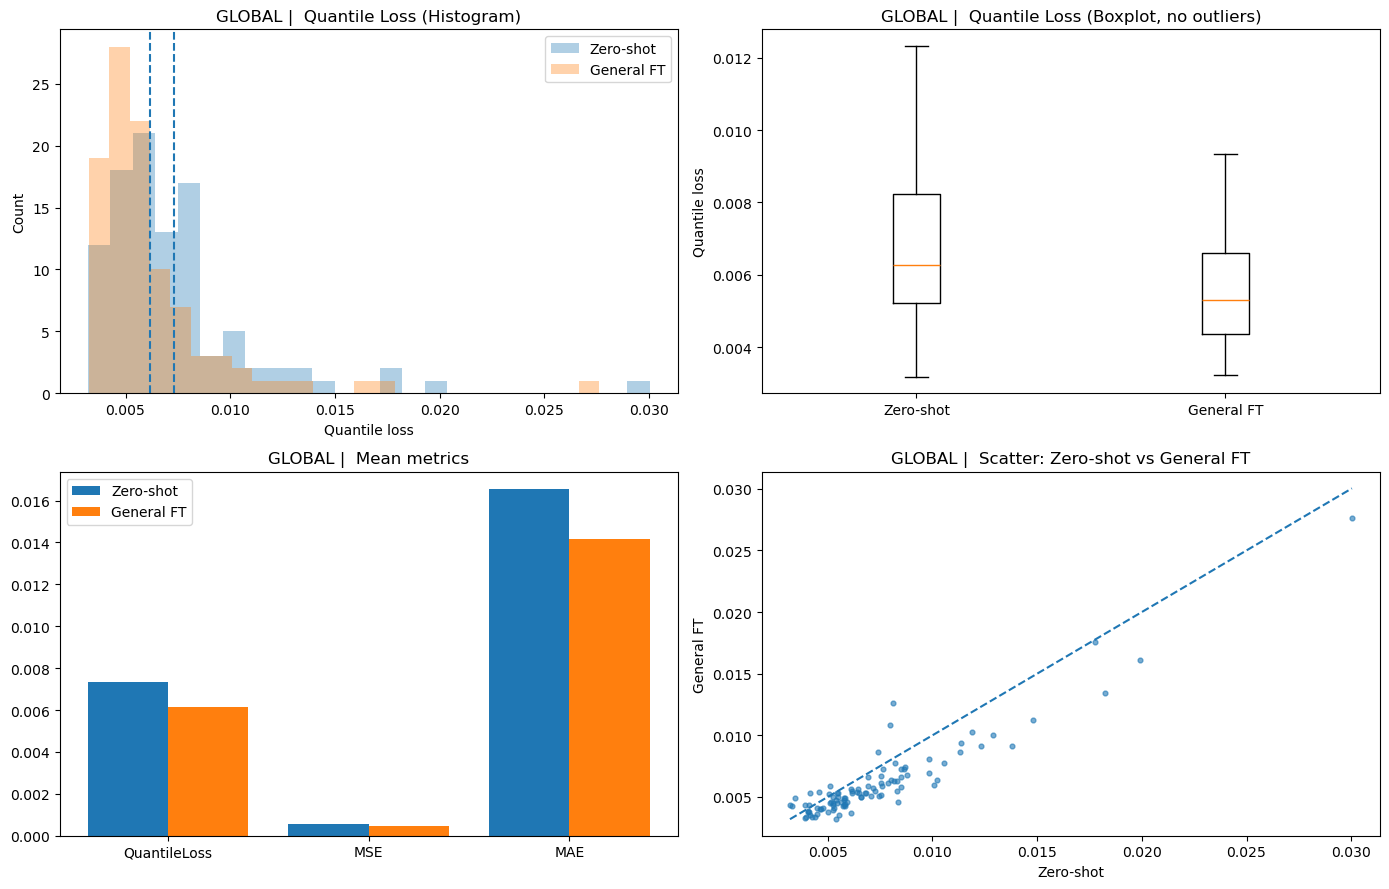

In [9]:
plot_eval_comparison(
    results_list=[
        ("Zero-shot", baseline_global_results),
        ("General FT", general_results_global),
    ],
    title_prefix="GLOBAL | "
)


C:\Users\sanit\AppData\Local\Temp\ipykernel_18712\3957317346.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(qloss_lists, labels=labels, showfliers=False)


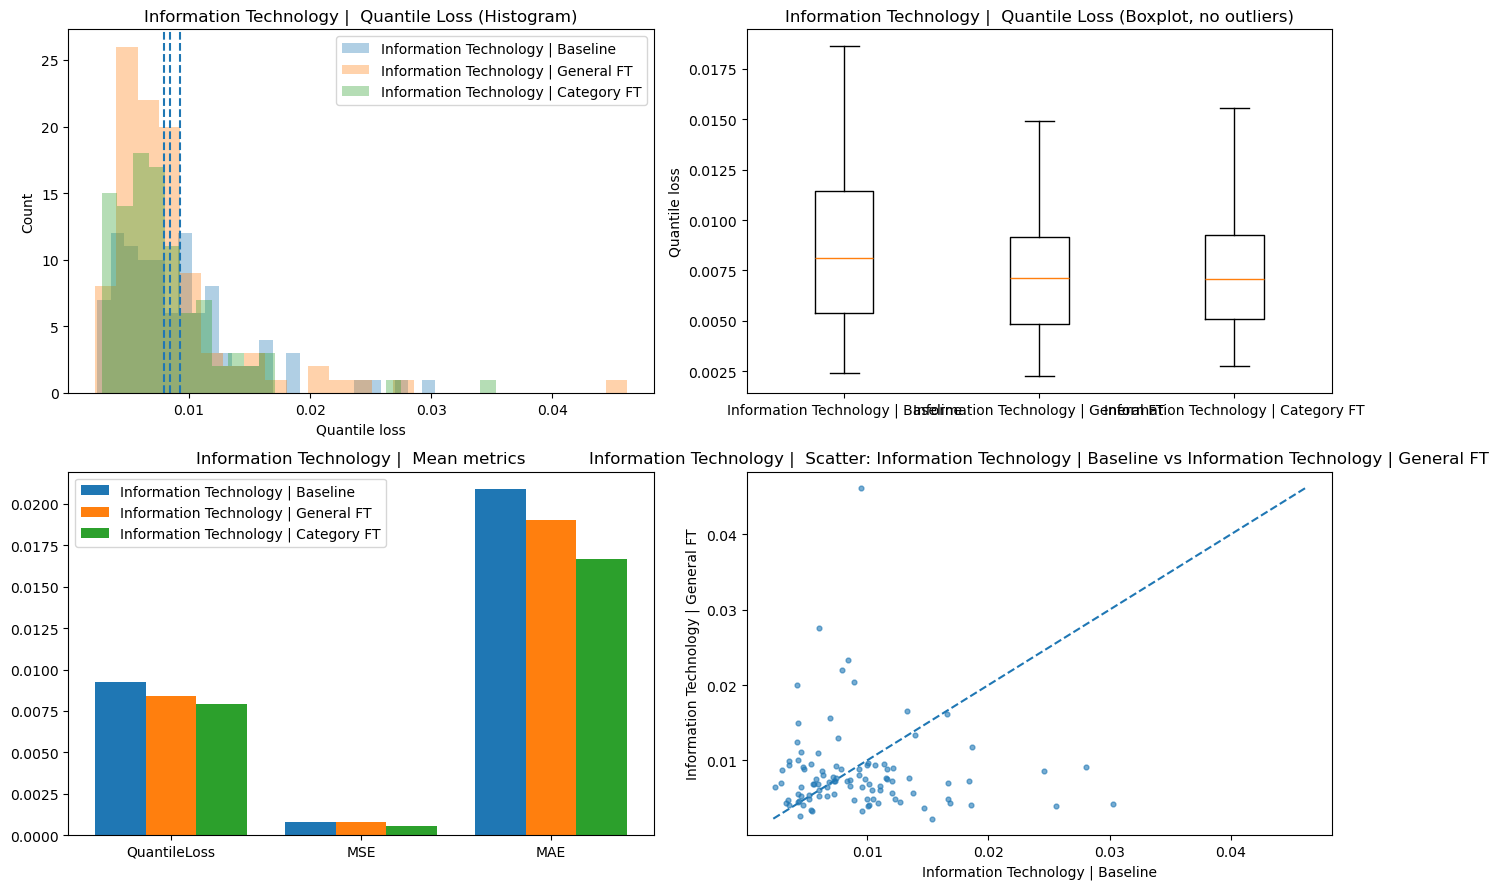

In [10]:
cat = "Information Technology"  # cambia categoria
res_base = category_comparisons[cat]["baseline"]
res_gen  = category_comparisons[cat]["general_finetuned"]
res_cat  = category_comparisons[cat]["category_finetuned"]

plot_eval_comparison(
    results_list=[
        (f"{cat} | Baseline", res_base),
        (f"{cat} | General FT", res_gen),
        (f"{cat} | Category FT", res_cat),
    ],
    title_prefix=f"{cat} | "
)


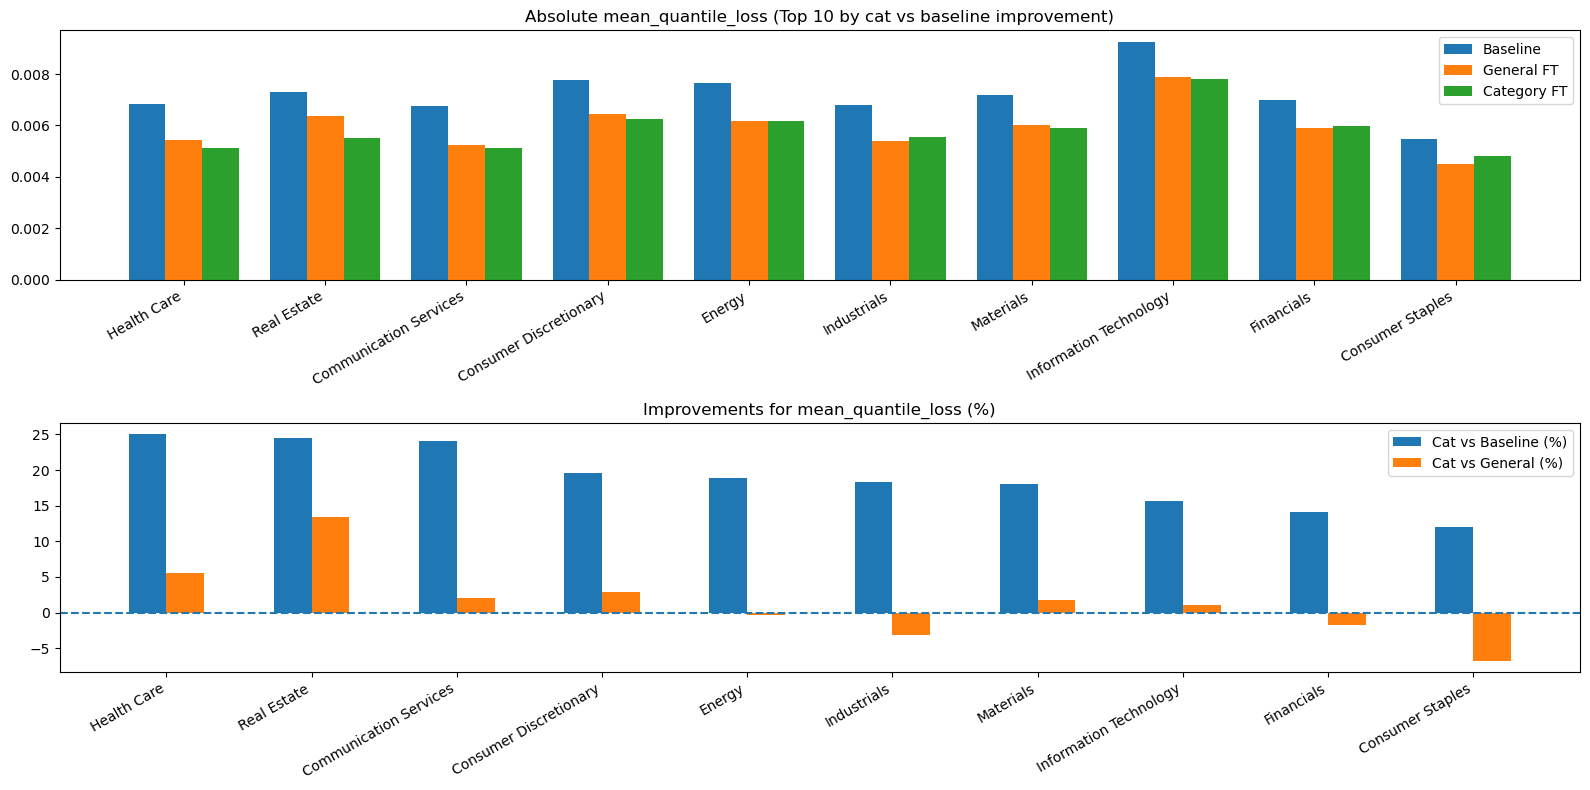

In [10]:
plot_category_summary(category_comparisons, metric="mean_quantile_loss", top_k=12)


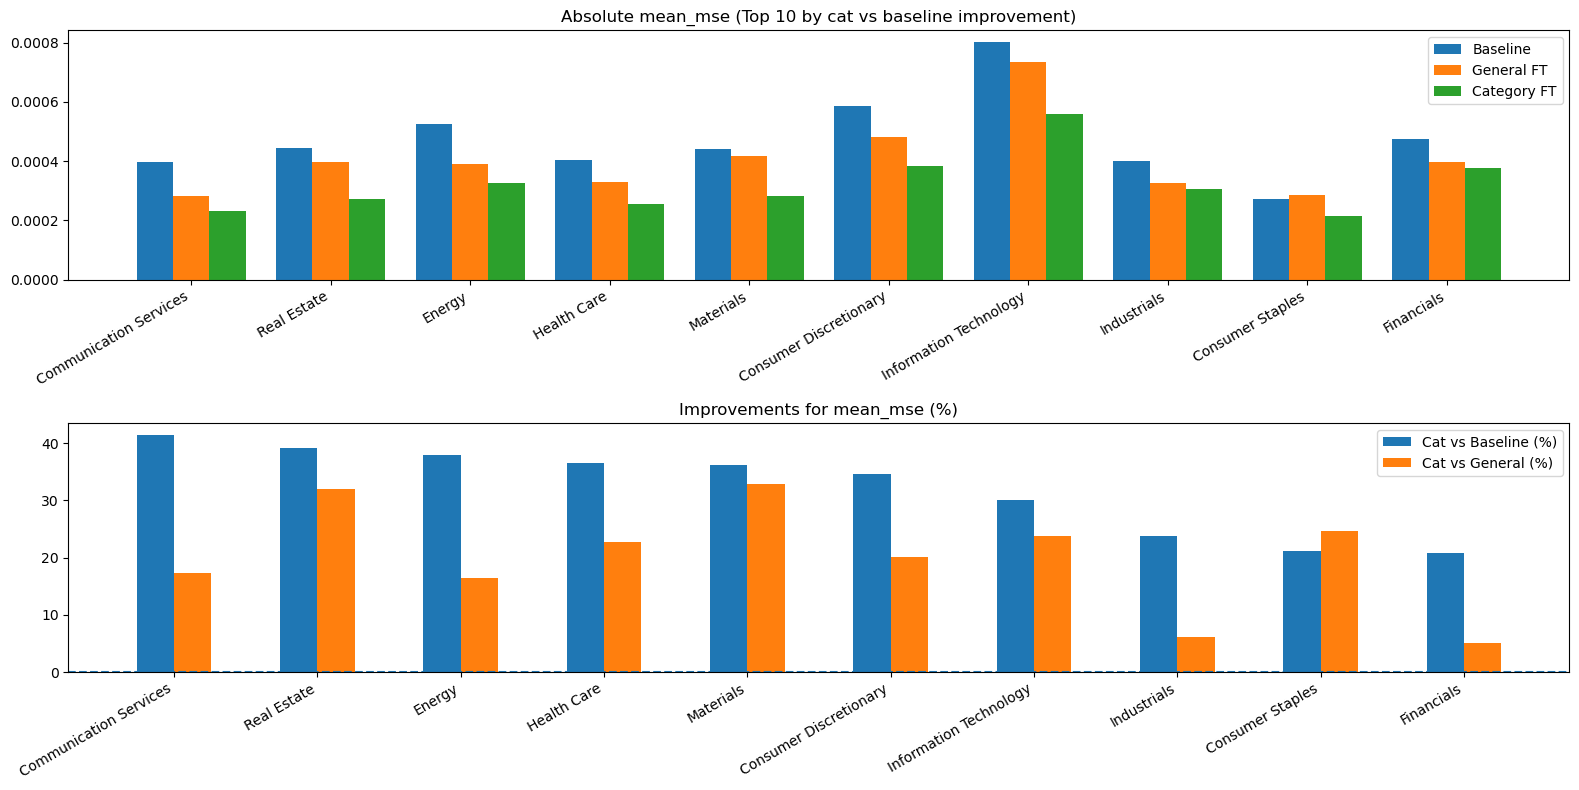

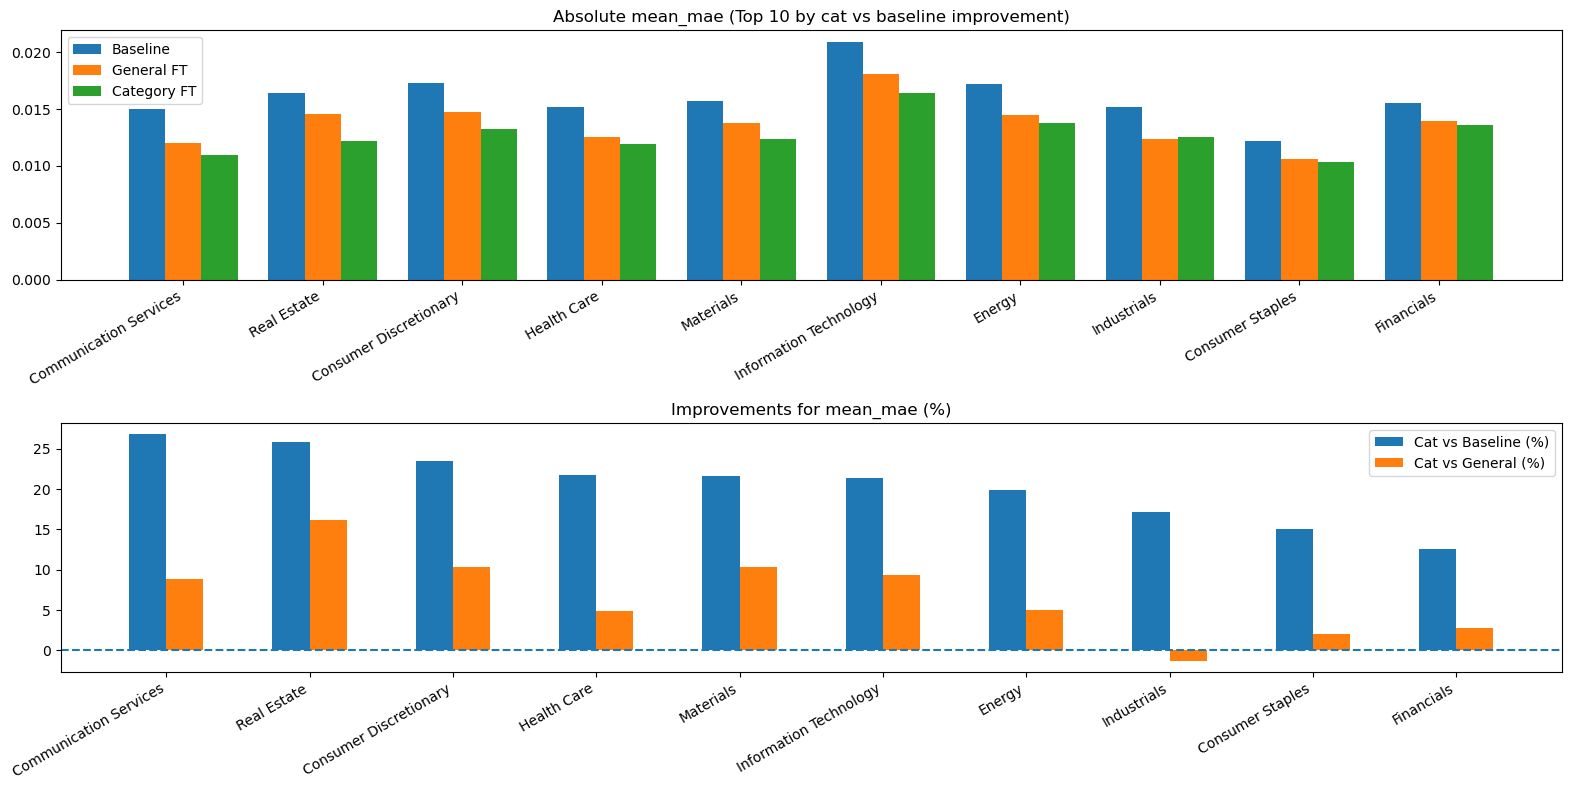

In [11]:
plot_category_summary(category_comparisons, metric="mean_mse", top_k=12)
plot_category_summary(category_comparisons, metric="mean_mae", top_k=12)


In [12]:
# Run sliding backtest on evaluation data
results = run_chronos_sliding_backtest(
    pipeline=finetuned_general,
    df_returns=df_eval_clean,
    device="cpu",
    context_length=context_length,
)

print(summarize_backtest_results(results))

100%|██████████| 999/999 [07:57<00:00,  2.09it/s]

{'mean_corr': np.float64(-0.014860180189626261), 'mean_r2': np.float64(-0.6926427514536639), 'mean_mse': np.float64(0.0004128894006748148), 'mean_mae': np.float64(0.014160042881244516)}


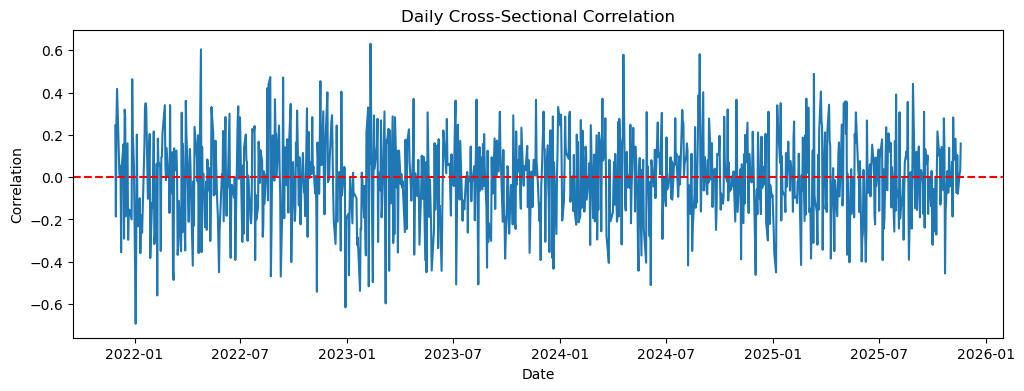

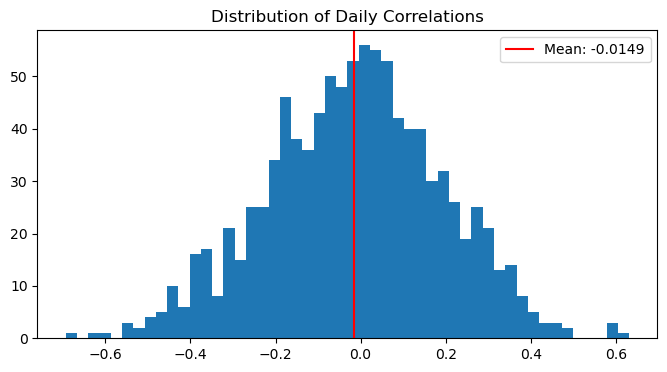

In [13]:
# Detailed analysis
preds = results["preds"]   # (T_eval, N)
trues = results["trues"]   # (T_eval, N)
dates = results["dates"]

# Plot correlation over time
correlations = [m["corr"] for m in results["daily_metrics"]]
plt.figure(figsize=(12, 4))
plt.plot(dates, correlations)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Daily Cross-Sectional Correlation")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.show()

# Distribution of correlations
plt.figure(figsize=(8, 4))
plt.hist(correlations, bins=50)
plt.axvline(x=np.mean(correlations), color='r', label=f'Mean: {np.mean(correlations):.4f}')
plt.title("Distribution of Daily Correlations")
plt.legend()
plt.show()